In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
# NOTE: Custome Module !!
from module.dataframe import df_query_by_type, series_string_filter

In [3]:
train = pd.read_parquet("./database/train.parquet")
test = pd.read_parquet("./database/test.parquet")

## 전처리

### 모든 값이 같은 열 삭제
---

In [4]:
# NOTE: 모든 값이 같은 열을 제거한다. 
is_unique = train.apply(pd.Series.unique, axis=0).apply(len)
is_unique[is_unique == len(train)].index, is_unique[is_unique == 1].index

(Index(['id'], dtype='object'),
 Index(['vehicle_restricted', 'height_restricted'], dtype='object'))

In [5]:
train = train.drop(columns=is_unique[is_unique == 1].index)
test = test.drop(columns=is_unique[is_unique == 1].index)

### 레이블로 변환하기
---

In [6]:
# 도로에 하중 제한이 있냐/없냐로 변환함.
train["weight_restricted"] = (train["weight_restricted"] != 0).astype(int)
test["weight_restricted"] = (test["weight_restricted"] != 0).astype(int)

In [7]:
# 구체적인 이름을 종류로 변환함.
tourism_road = ["관광단지", "관광도로"]
general_road = ["지방도", "일반국도", "길", "로"]
bridge_road = ["교", "천교"]
nontaged_road = ["-"]
def mapping_road(road_name):
    if sum([target in road_name for target in tourism_road]) > 0:
        return "tourism_road"
    elif sum([target in road_name for target in general_road]) > 0:
        return "general_road"
    elif sum([target in road_name for target in bridge_road]) > 0:
        return "bridge"
    elif sum([target in road_name for target in nontaged_road]) > 0:
        return "-"
    else:
        return "-"


train["road_type"] = train["road_name"].apply(mapping_road)
test["road_type"] = test["road_name"].apply(mapping_road)

In [8]:
train["road_type"].value_counts()

road_type
general_road    4028056
-                569463
tourism_road      55993
bridge            47705
Name: count, dtype: int64

In [9]:
test["road_type"].value_counts()

road_type
general_road    265853
-                12600
tourism_road      6957
bridge            5831
Name: count, dtype: int64

### 공휴일 처리

---


In [10]:
import holidays
kr_holidays = holidays.KR()

def to_date_str(int_date: int):
    day = int_date % 100
    year = (int_date - day) // 10000
    month = (int_date - year * 10000) // 100
    return f"{year}-{month:02}-{day:02}"

In [11]:
# 2m 14s <- O(n^2)인듯..?
train["is_holiday"] = train["base_date"].apply(to_date_str)
train["is_holiday"] = train["is_holiday"].apply(lambda _X: _X in kr_holidays)

test["is_holiday"] = test["base_date"].apply(to_date_str)
test["is_holiday"] = test["is_holiday"].apply(lambda _X: _X in kr_holidays)
train["is_holiday"].sum() / len(train["is_holiday"]) * 100

6.973513454069447

### `day_of_week, start/end_turn_restricted, road_type, is_holiday`을 `label`로 처리

---


In [12]:
# NOTE: 기존 코드에 있던 것임.
str_col = ["day_of_week", "start_turn_restricted", "end_turn_restricted", "road_type", "is_holiday","weight_restricted"]
for col in str_col:
    label_enc = LabelEncoder()
    label_enc = label_enc.fit(train[col])
    train[col] = label_enc.transform(train[col])

    for label in np.unique(test[col]):
        if label not in label_enc.classes_:
            label_enc.classes_ = np.append(label_enc.classes_, label)
            print(col, label_enc.classes_)
    test[col] = label_enc.transform(test[col])

In [13]:
# One-Hot Enc
train = pd.get_dummies(train, columns=str_col[:], dtype=int)
test = pd.get_dummies(test, columns=str_col[:], dtype=int)

In [14]:
"칼럼의 개수 같나요?",len(train.drop(columns="target").columns) == len(test.columns)

('칼럼의 개수 같나요?', True)

### 날짜처리
---

In [15]:
train["base_date_year"] = train["base_date"] // 10000
train["base_date_month"] = train["base_date"] // 100 % 100
train["base_date_day"] = train["base_date"] % 100
train = train.drop(columns="base_date")

test["base_date_year"] = test["base_date"] // 10000
test["base_date_month"] = test["base_date"] // 100 % 100
test["base_date_day"] = test["base_date"] % 100
test = test.drop(columns="base_date")

## Check Dataframe after preprocessing
---

In [16]:
train.head(0)

,id,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,start_node_name,start_latitude,...,road_type_1,road_type_2,road_type_3,is_holiday_0,is_holiday_1,weight_restricted_0,weight_restricted_1,base_date_year,base_date_month,base_date_day


## Final Preprocessing Function 

In [17]:
# NOTE: 모든 값이 같은 열을 제거한다.
def do_preprocessing(train, test):
    # non-unique 제거하기
    is_unique = train.apply(pd.Series.unique, axis=0).apply(len)
    is_unique[is_unique == len(train)].index, is_unique[is_unique == 1].index
    train = train.drop(columns=is_unique[is_unique == 1].index)
    test = test.drop(columns=is_unique[is_unique == 1].index)

    # weight_restricted - label추가하기
    train["weight_restricted"] = (train["weight_restricted"] != 0).astype(int)
    test["weight_restricted"] = (test["weight_restricted"] != 0).astype(int)

    # is_holiday - label추가하기
    train["is_holiday"] = train["base_date"].apply(to_date_str)
    test["is_holiday"] = test["base_date"].apply(to_date_str)
    train["is_holiday"] = train["is_holiday"].apply(lambda _X: _X in kr_holidays).astype(int)
    test["is_holiday"] = test["is_holiday"].apply(lambda _X: _X in kr_holidays).astype(int)

    # road_type - label추가하기
    train["road_type"] = train["road_name"].apply(mapping_road)
    test["road_type"] = test["road_name"].apply(mapping_road)

    # label encode.
    str_col = [
        "day_of_week",
        "start_turn_restricted",
        "end_turn_restricted",
        "road_type",
        "is_holiday",
        "weight_restricted",
    ]
    for col in str_col:
        label_enc = LabelEncoder()
        label_enc = label_enc.fit(train[col])
        train[col] = label_enc.transform(train[col])

        for label in np.unique(test[col]):
            if label not in label_enc.classes_:
                label_enc.classes_ = np.append(label_enc.classes_, label)
        test[col] = label_enc.transform(test[col])

    # One-Hot Enc
    train = pd.get_dummies(
        train,
        columns=str_col[:],
        dtype=int,
    )
    test = pd.get_dummies(
        test,
        columns=str_col[:],
        dtype=int,
    )

    # 날짜 삽입입
    train["base_date_year"] = train["base_date"] // 10000
    train["base_date_month"] = train["base_date"] // 100 % 100
    train["base_date_day"] = train["base_date"] % 100
    train = train.drop(columns="base_date")

    test["base_date_year"] = test["base_date"] // 10000
    test["base_date_month"] = test["base_date"] // 100 % 100
    test["base_date_day"] = test["base_date"] % 100
    test = test.drop(columns="base_date")

    # 문자형 데이터 제거하기.
    train = pd.concat([df_query_by_type(train, float), df_query_by_type(train, int)], axis=1)
    test = pd.concat([df_query_by_type(test, float), df_query_by_type(test, int)], axis=1)

    # 좌표 정보 제거하기.
    train = train.drop(columns=["start_latitude", "start_longitude", "end_latitude", "end_longitude"])
    test = test.drop(columns=["start_latitude", "start_longitude", "end_latitude", "end_longitude"])

    return train, test

---

<Axes: >

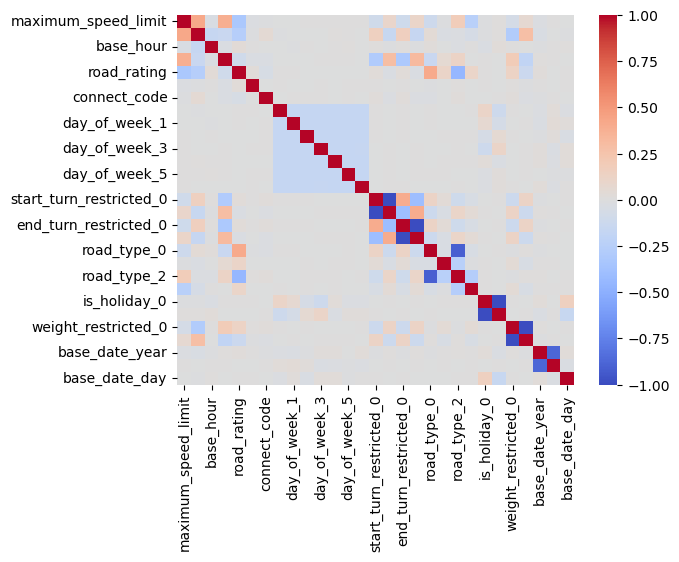

In [18]:
df_numberic = pd.concat([df_query_by_type(train, float), df_query_by_type(train, int)], axis=1)
df_numberic = df_numberic.drop(columns=["start_latitude", "start_longitude", "end_latitude", "end_longitude"])

sns.heatmap(df_numberic.corr(), vmax=1, vmin=-1, cmap="coolwarm")